# Break Through Tech - Allstate 1B
## Author: Tahia Islam
### Ridge Regression Model

Numerical features must be scaled because ridge works by penalizing large coefficients, so it's important to have all the features on the same scale.

Can be scaled by Pipeline

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


In [2]:
df = pd.read_csv('../data/claims_data.csv')

### Transform Target Variable

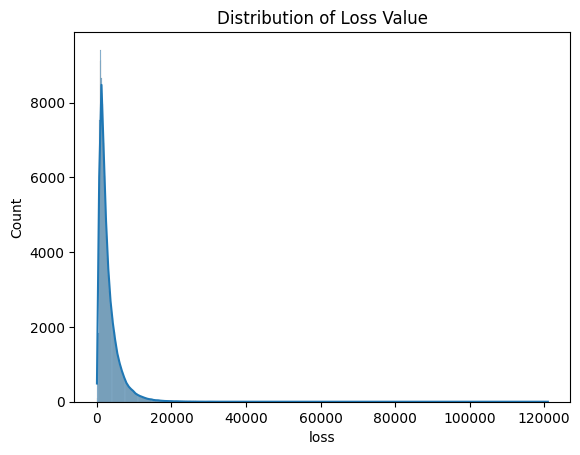

In [3]:
sns.histplot(df['loss'], kde = True)
plt.title("Distribution of Loss Value")
plt.show()

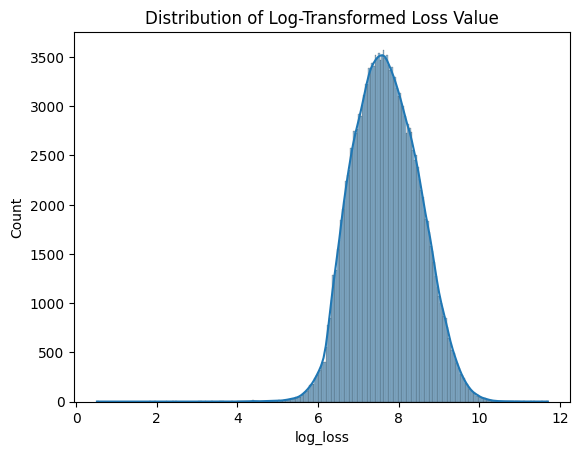

In [4]:
df['log_loss'] = np.log1p(df['loss'])
sns.histplot(df['log_loss'], kde='True')
plt.title('Distribution of Log-Transformed Loss Value')
plt.show()

### Ridge Regression

In [5]:
y = df['log_loss']

In [6]:
# # define numerical and catgeorical features
# categorical_cols = [c for c in df.columns if c.startswith("cat") and df[c].nunique() == 2]
# numerical_cols = [c for c in df.columns if c.startswith("cont")]
# X = df[numerical_cols + categorical_cols]

In [7]:
# testing -  Define feature lists
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
if 'loss' in numerical_features: numerical_features.remove('loss')
if 'log_loss' in numerical_features: numerical_features.remove('log_loss')
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

X = df[numerical_features + categorical_features]
y = df['log_loss']

### Preprocessing Pipeline

We must scale numerical data

In [8]:
# create transformer for numerical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# create transformer for categorical data
catgeorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# now combine using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', catgeorical_transformer, categorical_features)
])

### Create Model Pipeline

This chainlinks the preprocessing and the Ridge Regression model.

In [9]:
ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

### Rdige Regression Before Tuning

In [10]:
# split data
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y, test_size=0.2, random_state=42)

print("--- Results BEFORE Tuning (Default alpha=1.0) ---")
# fit the model
ridge_model.fit(X_train, y_train_log)

# make predictions
log_predictions_before = ridge_model.predict(X_test)

# mae = mean_absolute_error(y_test_original, original_predictions)
mae_log_before = mean_absolute_error(y_test_log, log_predictions_before)
r2_log_before = r2_score(y_test_log, log_predictions_before)
# rmse = np.sqrt(mean_squared_error(y_test_original, original_predictions))

# ----Evaluate on the original scale-----
# convert both predictions and test target back to original 'loss' scale
original_predictions_before = np.expm1(log_predictions_before)
y_test_original = np.expm1(y_test_log)
mae_before = mean_absolute_error(y_test_original, original_predictions_before)

print(f"R-squared (log scale): {r2_log_before:.4f}")
print(f"MAE (log scale): {mae_log_before:.4f}")
print(f"MAE (original scale): ${mae_before:,.2f}\n")

--- Results BEFORE Tuning (Default alpha=1.0) ---
R-squared (log scale): 0.5186
MAE (log scale): 0.4400
MAE (original scale): $1,244.70



### Hyperparameter Tuning using GridSearchCV

In [10]:
# ----HYPERPARAMETER TUNING----
print("--- Running GridSearchCV to find best alpha... ---")

# Define a range of 'alpha' values to test
# We use 'regressor__alpha' because 'regressor' is the name of the Ridge step in your pipeline
param_grid = {
    'regressor__alpha': np.logspace(-2, 3, 20)  # 20 values from 0.01 to 1000
}

# GridSearchCV Setup
grid_search = GridSearchCV(
    ridge_model,
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    verbose=1
)

# run the tuning
grid_search.fit(X_train, y_train_log)

# get best parameter
best_alpha = grid_search.best_params_['regressor__alpha']
print(f"Best alpha found: {best_alpha:.4f}\n")


--- Running GridSearchCV to find best alpha... ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best alpha found: 4.2813



### Using best alpha

In [11]:
print("--- Results AFTER Tuning (Best alpha) ---")

log_predictions_after = grid_search.predict(X_test)

# evaluate
mae_log_after = mean_absolute_error(y_test_log, log_predictions_after)
r2_log_after = r2_score(y_test_log, log_predictions_after)

# original scale
original_predictions_after = np.expm1(log_predictions_after)
mae_after = mean_absolute_error(y_test_original, original_predictions_after)

print(f"R-squared (log scale): {r2_log_after:.4f}")
print(f"MAE (log scale): {mae_log_after:.4f}")
print(f"MAE (original scale): ${mae_after:,.2f}\n")

--- Results AFTER Tuning (Best alpha) ---
R-squared (log scale): 0.4055
MAE (log scale): 0.4906
MAE (original scale): $1,425.19



--- 4. Generating Validation Plot... ---


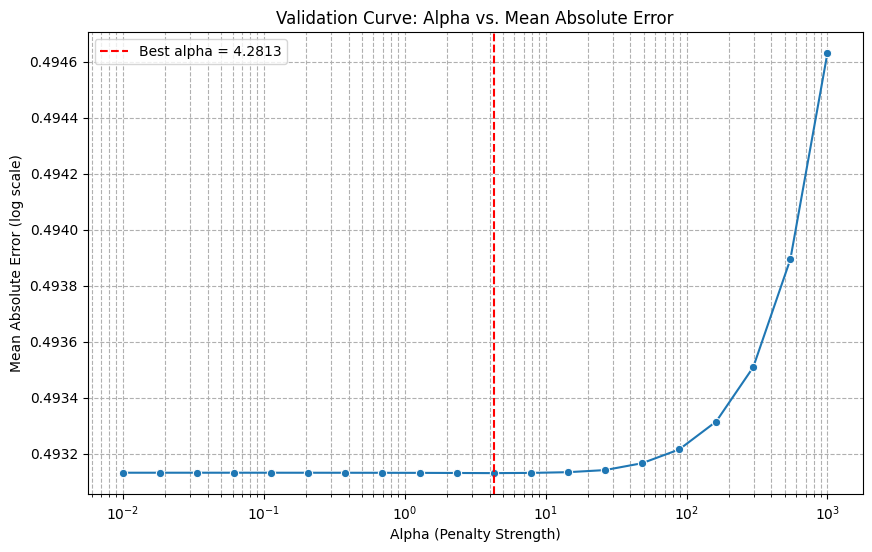

In [12]:
print("--- 4. Generating Validation Plot... ---")

# Get the results from the grid search
cv_results = grid_search.cv_results_
alphas = cv_results['param_regressor__alpha']
# We multiply by -1 because the score is 'neg_mean_absolute_error'
mean_test_scores = -cv_results['mean_test_score']

plt.figure(figsize=(10, 6))
sns.lineplot(x=alphas, y=mean_test_scores, marker='o')
plt.xscale('log')  # Use a log scale for alpha
plt.title('Validation Curve: Alpha vs. Mean Absolute Error')
plt.xlabel('Alpha (Penalty Strength)')
plt.ylabel('Mean Absolute Error (log scale)')
plt.grid(True, which="both", ls="--")

# Add a vertical line to show where the best alpha is
plt.axvline(x=best_alpha, color='red', linestyle='--', 
            label=f'Best alpha = {best_alpha:.4f}')
plt.legend()
plt.show()

### Analysis
Mean Absolute Error (MAE) -  measures the average size of the errors in your predictions.

We have MAE on log scale and on original loss scale. 

We see that on average, the model's prediction of the loss is off by about $1,425.26

---Next steps---
- Make definitions for rsme, etc.
- Analysis of the plot above.
- Pros and Cons, benefits of this model